This is the banchmarking of the network architecture 

In [28]:
from Medfl.LearningManager.utils import global_params

import sys
sys.path.append(global_params['base_url'])

import os
os.environ['PYTHONPATH'] = global_params['base_url']

In [29]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

## MedFL Imports 
## Network Manager Imports 
from Medfl.NetManager.node import Node
from Medfl.NetManager.network import Network
from Medfl.NetManager.dataset import DataSet
from Medfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from Medfl.LearningManager.dynamicModal import DynamicModel
from Medfl.LearningManager.model import Model
from Medfl.LearningManager.strategy import Strategy
from Medfl.LearningManager.server import *
from Medfl.LearningManager.flpipeline import *
from Medfl.LearningManager.plot import AccuracyLossPlotter



# Utils
from Medfl.LearningManager.utils import *


In [30]:
# DB Creation 
!python3 ../../../scripts/create_db.py

# clearn DB 
# empty_db()

In [31]:
# Create a nest work "Net_1"
Net_1 = Network(name="manual_network_2")
Net_1.create_network()

Net_1.name

'manual_network_2'

In [32]:
# Create a MasterDataSet from Net_1
Net_1.create_master_dataset()

# Check if the Network has a masterDataSet Table ( 1: Table exists ; 0: Table doesn't exist)
Net_1.mtable_exists

/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/notebooks/data/masterDataSet/Mimic_train.csv


1

In [33]:
# auto FLsetup creation
autoFl  = FLsetup(name = "Flsetup_2", description = "The second fl setup",network = Net_1)
autoFl.create()

# List all setups 
FLsetup.list_allsetups()

,FLsetupId,name,description,creation_date,NetId,column_name
0,1,Flsetup_2,The second fl setup,2024-02-21 14:43:58,1,None


# Configuration_1: A Manual network with 50 Nodes 
This network contains 50 nodes (40 Train nodes and 10 test nodes)

In [34]:
# Create 40 train nodes
for i in range(1,40):
    hospital = Node(name="hospital_"+str(i) , train=1)
    Net_1.add_node(hospital)
    hospital.upload_dataset("hospital_"+str(i)+'_dataset' , global_params['base_url']+ '/notebooks/data/nodesData/part_'+str(i)+'.csv')


In [35]:
# Create 10 test nodes
for i in range(1,11):
    hospital = Node(name="hospital_"+str(40+i) , train=0)
    Net_1.add_node(hospital)
    hospital.upload_dataset("hospital_"+str(40+i)+'_dataset' , global_params['base_url']+ '/notebooks/data/nodesData/test_'+str(i)+'.csv')

In [36]:
# List all created nodes on the db 
Node.list_allnodes()

,NodeId,NodeName,train,NetId
0,1,hospital_1,1,1
1,2,hospital_2,1,1
2,3,hospital_3,1,1
3,4,hospital_4,1,1
4,5,hospital_5,1,1
5,6,hospital_6,1,1
6,7,hospital_7,1,1
7,8,hospital_8,1,1
8,9,hospital_9,1,1
9,10,hospital_10,1,1


In [37]:
# Create FLDataSet
fl_dataset = autoFl.create_federated_dataset(
    output="deceased", 
    fit_encode=[], 
    to_drop=[ "deceased" ]
    )

In [38]:
fl_dataset.size

17

In [39]:
# Creating a DynamicModel instance
dynamic_model = DynamicModel()

# Creating a specific model dynamically using DynamicModel
specific_model = dynamic_model.create_model(model_type='Logistic Regressor', params_dict={"input_dim": 17, "output_dim": 1})

# Pass the specific_model to the Model class
optimizer = optim.SGD(specific_model.parameters(), lr=0.0001)
criterion = nn.BCELoss()


# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(specific_model, optimizer, criterion)

# The modal to be passed to the server
global_model.get_parameters()

[array([[-0.17698361,  0.02907571,  0.10331208,  0.09876631, -0.00965721,
         -0.13426843, -0.00488413, -0.12790611, -0.03850526,  0.13885623,
         -0.17172442,  0.20407529, -0.06908856, -0.06273044, -0.1131157 ,
          0.07227229, -0.2369845 ]], dtype=float32),
 array([0.14717168], dtype=float32)]

In [40]:
# Create the strategy
fed_avg = Strategy("FedAvg", 
                   fraction_fit = 1.0 ,
                   fraction_evaluate = 1.0,
                   min_fit_clients = 2,
                   min_evaluate_clients = 2,
                   min_available_clients = 2 , 
                   initial_parameters=global_model.get_parameters())

In [41]:
# Create The server 
server = FlowerServer(global_model, strategy = fed_avg, num_rounds = 50,
                       num_clients  = len(fl_dataset.trainloaders), 
                       fed_dataset = fl_dataset,diff_privacy = False ,
                       # You can change the resources alocated for each client based on your machine 
                       client_resources={'num_cpus': 1.0, 'num_gpus': 0.0}
                       )

In [42]:
# Create the pipeline 
ppl_1 = FLpipeline( name ="the first fl_pipeline",description = "this is our first FL pipeline",
                   server = server)

In [43]:
# Run the Traning of the model
history = ppl_1.server.run()

INFO flwr 2024-02-21 14:44:24,971 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
02/21/2024 14:44:24:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-21 14:44:29,066	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-21 14:44:31,402 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 24.0, 'memory': 40890896794.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
02/21/2024 14:44:31:INFO:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 24.0, 'memory': 40890896794.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
INFO flwr 2024-02-21 14:44:31,403 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
02/21/2024 14:44:31:INFO:Opt

Server-side evaluation loss 7.439686861905185 / accuracy 0.18181818181818182


(DefaultActor pid=389476) /home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/utils.py:19: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
(DefaultActor pid=389476)   global_yaml_path = pkg_resources.resource_filename(__name__, "../../global_params.yaml")


(DefaultActor pid=389476) [Client 31] fit, config: {}
(DefaultActor pid=389476) epsilon of client 31 : eps = 0
(DefaultActor pid=389476) [Client 15] fit, config: {}


(DefaultActor pid=389476) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=389476)   warnings.warn(
(DefaultActor pid=389476) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=389476)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=389476) epsilon of client 15 : eps = 0
(DefaultActor pid=389476) [Client 36] fit, config: {}
(DefaultActor pid=389476) epsilon of client 36 : eps = 0


DEBUG flwr 2024-02-21 14:44:40,901 | server.py:236 | fit_round 1 received 39 results and 0 failures
02/21/2024 14:44:40:DEBUG:fit_round 1 received 39 results and 0 failures
WARNING flwr 2024-02-21 14:44:40,912 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
02/21/2024 14:44:40:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-02-21 14:44:40,915 | server.py:125 | fit progress: (1, 7.455976312810725, {'accuracy': 0.09090909090909091}, 9.494280820013955)
02/21/2024 14:44:40:INFO:fit progress: (1, 7.455976312810725, {'accuracy': 0.09090909090909091}, 9.494280820013955)
DEBUG flwr 2024-02-21 14:44:40,916 | server.py:173 | evaluate_round 1: strategy sampled 39 clients (out of 39)
02/21/2024 14:44:40:DEBUG:evaluate_round 1: strategy sampled 39 clients (out of 39)


Server-side evaluation loss 7.455976312810725 / accuracy 0.09090909090909091
(DefaultActor pid=389470) [Client 31] evaluate, config: {}


DEBUG flwr 2024-02-21 14:44:42,108 | server.py:187 | evaluate_round 1 received 39 results and 0 failures
02/21/2024 14:44:42:DEBUG:evaluate_round 1 received 39 results and 0 failures
WARNING flwr 2024-02-21 14:44:42,109 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
02/21/2024 14:44:42:WARNING:No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-21 14:44:42,111 | server.py:222 | fit_round 2: strategy sampled 39 clients (out of 39)
02/21/2024 14:44:42:DEBUG:fit_round 2: strategy sampled 39 clients (out of 39)
DEBUG flwr 2024-02-21 14:44:42,835 | server.py:236 | fit_round 2 received 39 results and 0 failures
02/21/2024 14:44:42:DEBUG:fit_round 2 received 39 results and 0 failures
INFO flwr 2024-02-21 14:44:42,847 | server.py:125 | fit progress: (2, 0.9220985065806996, {'accuracy': 0.8181818181818182}, 11.425510909059085)
02/21/2024 14:44:42:INFO:fit progress: (2, 0.9220985065806996, {'accuracy': 0.8181818181818182}, 11.425510909059085)
DEBUG flwr 2024-02-21 14:44

Server-side evaluation loss 0.9220985065806996 / accuracy 0.8181818181818182


DEBUG flwr 2024-02-21 14:44:43,360 | server.py:187 | evaluate_round 2 received 39 results and 0 failures
02/21/2024 14:44:43:DEBUG:evaluate_round 2 received 39 results and 0 failures
DEBUG flwr 2024-02-21 14:44:43,361 | server.py:222 | fit_round 3: strategy sampled 39 clients (out of 39)
02/21/2024 14:44:43:DEBUG:fit_round 3: strategy sampled 39 clients (out of 39)
DEBUG flwr 2024-02-21 14:44:44,080 | server.py:236 | fit_round 3 received 39 results and 0 failures
02/21/2024 14:44:44:DEBUG:fit_round 3 received 39 results and 0 failures
INFO flwr 2024-02-21 14:44:44,091 | server.py:125 | fit progress: (3, 0.9185468500310724, {'accuracy': 0.8181818181818182}, 12.670179654029198)
02/21/2024 14:44:44:INFO:fit progress: (3, 0.9185468500310724, {'accuracy': 0.8181818181818182}, 12.670179654029198)
DEBUG flwr 2024-02-21 14:44:44,092 | server.py:173 | evaluate_round 3: strategy sampled 39 clients (out of 39)
02/21/2024 14:44:44:DEBUG:evaluate_round 3: strategy sampled 39 clients (out of 39)


Server-side evaluation loss 0.9185468500310724 / accuracy 0.8181818181818182
(DefaultActor pid=389485) [Client 8] fit, config: {} [repeated 114x across cluster]
(DefaultActor pid=389485) epsilon of client 8 : eps = 0 [repeated 114x across cluster]
(DefaultActor pid=389466) [Client 35] evaluate, config: {} [repeated 84x across cluster]


(DefaultActor pid=389485) /home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/utils.py:19: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release. [repeated 23x across cluster]
(DefaultActor pid=389485)   global_yaml_path = pkg_resources.resource_filename(__name__, "../../global_params.yaml") [repeated 23x across cluster]
(DefaultActor pid=389485) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 102x across cluster]
(DefaultActor pid=389485)   warnings.warn( [repeated 102x across cluster]
(DefaultActor pid=389485) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transpor

(DefaultActor pid=389459) [Client 27] evaluate, config: {} [repeated 13x across cluster]
(DefaultActor pid=389483) [Client 32] fit, config: {}
(DefaultActor pid=389483) epsilon of client 32 : eps = 0


DEBUG flwr 2024-02-21 14:44:52,931 | server.py:236 | fit_round 4 received 39 results and 0 failures
02/21/2024 14:44:52:DEBUG:fit_round 4 received 39 results and 0 failures
INFO flwr 2024-02-21 14:44:52,943 | server.py:125 | fit progress: (4, 0.9040998112071644, {'accuracy': 0.8181818181818182}, 21.521962405066006)
02/21/2024 14:44:52:INFO:fit progress: (4, 0.9040998112071644, {'accuracy': 0.8181818181818182}, 21.521962405066006)
DEBUG flwr 2024-02-21 14:44:52,944 | server.py:173 | evaluate_round 4: strategy sampled 39 clients (out of 39)
02/21/2024 14:44:52:DEBUG:evaluate_round 4: strategy sampled 39 clients (out of 39)


Server-side evaluation loss 0.9040998112071644 / accuracy 0.8181818181818182


DEBUG flwr 2024-02-21 14:44:53,537 | server.py:187 | evaluate_round 4 received 39 results and 0 failures
02/21/2024 14:44:53:DEBUG:evaluate_round 4 received 39 results and 0 failures
DEBUG flwr 2024-02-21 14:44:53,539 | server.py:222 | fit_round 5: strategy sampled 39 clients (out of 39)
02/21/2024 14:44:53:DEBUG:fit_round 5: strategy sampled 39 clients (out of 39)
DEBUG flwr 2024-02-21 14:44:54,251 | server.py:236 | fit_round 5 received 39 results and 0 failures
02/21/2024 14:44:54:DEBUG:fit_round 5 received 39 results and 0 failures
INFO flwr 2024-02-21 14:44:54,263 | server.py:125 | fit progress: (5, 0.9089299115267667, {'accuracy': 0.8181818181818182}, 22.841707914019935)
02/21/2024 14:44:54:INFO:fit progress: (5, 0.9089299115267667, {'accuracy': 0.8181818181818182}, 22.841707914019935)
DEBUG flwr 2024-02-21 14:44:54,264 | server.py:173 | evaluate_round 5: strategy sampled 39 clients (out of 39)
02/21/2024 14:44:54:DEBUG:evaluate_round 5: strategy sampled 39 clients (out of 39)


Server-side evaluation loss 0.9089299115267667 / accuracy 0.8181818181818182


(DefaultActor pid=389483) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 85x across cluster]
(DefaultActor pid=389483)   warnings.warn( [repeated 85x across cluster]
(DefaultActor pid=389483) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 85x across cluster]
(DefaultActor pid=389483)   client = check_client

(DefaultActor pid=389483) [Client 20] evaluate, config: {} [repeated 92x across cluster]
(DefaultActor pid=389476) [Client 13] fit, config: {} [repeated 77x across cluster]
(DefaultActor pid=389463) epsilon of client 7 : eps = 0 [repeated 77x across cluster]


DEBUG flwr 2024-02-21 14:45:00,947 | server.py:187 | evaluate_round 5 received 39 results and 0 failures
02/21/2024 14:45:00:DEBUG:evaluate_round 5 received 39 results and 0 failures
DEBUG flwr 2024-02-21 14:45:00,948 | server.py:222 | fit_round 6: strategy sampled 39 clients (out of 39)
02/21/2024 14:45:00:DEBUG:fit_round 6: strategy sampled 39 clients (out of 39)
DEBUG flwr 2024-02-21 14:45:02,659 | server.py:236 | fit_round 6 received 39 results and 0 failures
02/21/2024 14:45:02:DEBUG:fit_round 6 received 39 results and 0 failures
INFO flwr 2024-02-21 14:45:02,671 | server.py:125 | fit progress: (6, 0.8756224892356179, {'accuracy': 0.8181818181818182}, 31.249447189969942)
02/21/2024 14:45:02:INFO:fit progress: (6, 0.8756224892356179, {'accuracy': 0.8181818181818182}, 31.249447189969942)
DEBUG flwr 2024-02-21 14:45:02,671 | server.py:173 | evaluate_round 6: strategy sampled 39 clients (out of 39)
02/21/2024 14:45:02:DEBUG:evaluate_round 6: strategy sampled 39 clients (out of 39)


Server-side evaluation loss 0.8756224892356179 / accuracy 0.8181818181818182


DEBUG flwr 2024-02-21 14:45:03,192 | server.py:187 | evaluate_round 6 received 39 results and 0 failures
02/21/2024 14:45:03:DEBUG:evaluate_round 6 received 39 results and 0 failures
DEBUG flwr 2024-02-21 14:45:03,193 | server.py:222 | fit_round 7: strategy sampled 39 clients (out of 39)
02/21/2024 14:45:03:DEBUG:fit_round 7: strategy sampled 39 clients (out of 39)
DEBUG flwr 2024-02-21 14:45:03,921 | server.py:236 | fit_round 7 received 39 results and 0 failures
02/21/2024 14:45:03:DEBUG:fit_round 7 received 39 results and 0 failures
INFO flwr 2024-02-21 14:45:03,936 | server.py:125 | fit progress: (7, 0.889798337763006, {'accuracy': 0.8181818181818182}, 32.51441371499095)
02/21/2024 14:45:03:INFO:fit progress: (7, 0.889798337763006, {'accuracy': 0.8181818181818182}, 32.51441371499095)
DEBUG flwr 2024-02-21 14:45:03,937 | server.py:173 | evaluate_round 7: strategy sampled 39 clients (out of 39)
02/21/2024 14:45:03:DEBUG:evaluate_round 7: strategy sampled 39 clients (out of 39)


(DefaultActor pid=389465) [Client 36] evaluate, config: {} [repeated 44x across cluster]
(DefaultActor pid=389485) [Client 30] fit, config: {} [repeated 78x across cluster]
(DefaultActor pid=389462) epsilon of client 12 : eps = 0 [repeated 68x across cluster]
Server-side evaluation loss 0.889798337763006 / accuracy 0.8181818181818182


(DefaultActor pid=389477) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 69x across cluster]
(DefaultActor pid=389477)   warnings.warn( [repeated 69x across cluster]
(DefaultActor pid=389477) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 69x across cluster]
(DefaultActor pid=389477)   client = check_client

(DefaultActor pid=389508) [Client 1] evaluate, config: {} [repeated 35x across cluster]
(DefaultActor pid=389463) epsilon of client 36 : eps = 0 [repeated 10x across cluster]


DEBUG flwr 2024-02-21 14:45:12,036 | server.py:187 | evaluate_round 7 received 39 results and 0 failures
02/21/2024 14:45:12:DEBUG:evaluate_round 7 received 39 results and 0 failures
DEBUG flwr 2024-02-21 14:45:12,037 | server.py:222 | fit_round 8: strategy sampled 39 clients (out of 39)
02/21/2024 14:45:12:DEBUG:fit_round 8: strategy sampled 39 clients (out of 39)


(DefaultActor pid=389479) [Client 34] fit, config: {}


DEBUG flwr 2024-02-21 14:45:12,686 | server.py:236 | fit_round 8 received 39 results and 0 failures
02/21/2024 14:45:12:DEBUG:fit_round 8 received 39 results and 0 failures
INFO flwr 2024-02-21 14:45:12,703 | server.py:125 | fit progress: (8, 0.8936070528897372, {'accuracy': 0.8181818181818182}, 41.2815182430204)
02/21/2024 14:45:12:INFO:fit progress: (8, 0.8936070528897372, {'accuracy': 0.8181818181818182}, 41.2815182430204)
DEBUG flwr 2024-02-21 14:45:12,703 | server.py:173 | evaluate_round 8: strategy sampled 39 clients (out of 39)
02/21/2024 14:45:12:DEBUG:evaluate_round 8: strategy sampled 39 clients (out of 39)


Server-side evaluation loss 0.8936070528897372 / accuracy 0.8181818181818182


DEBUG flwr 2024-02-21 14:45:13,267 | server.py:187 | evaluate_round 8 received 39 results and 0 failures
02/21/2024 14:45:13:DEBUG:evaluate_round 8 received 39 results and 0 failures
DEBUG flwr 2024-02-21 14:45:13,269 | server.py:222 | fit_round 9: strategy sampled 39 clients (out of 39)
02/21/2024 14:45:13:DEBUG:fit_round 9: strategy sampled 39 clients (out of 39)
DEBUG flwr 2024-02-21 14:45:14,020 | server.py:236 | fit_round 9 received 39 results and 0 failures
02/21/2024 14:45:14:DEBUG:fit_round 9 received 39 results and 0 failures
INFO flwr 2024-02-21 14:45:14,031 | server.py:125 | fit progress: (9, 0.9029180353338068, {'accuracy': 0.8181818181818182}, 42.609897064976394)
02/21/2024 14:45:14:INFO:fit progress: (9, 0.9029180353338068, {'accuracy': 0.8181818181818182}, 42.609897064976394)
DEBUG flwr 2024-02-21 14:45:14,032 | server.py:173 | evaluate_round 9: strategy sampled 39 clients (out of 39)
02/21/2024 14:45:14:DEBUG:evaluate_round 9: strategy sampled 39 clients (out of 39)


Server-side evaluation loss 0.9029180353338068 / accuracy 0.8181818181818182
(DefaultActor pid=389507) [Client 35] evaluate, config: {} [repeated 55x across cluster]
(DefaultActor pid=389463) epsilon of client 26 : eps = 0 [repeated 78x across cluster]


(DefaultActor pid=389507) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 68x across cluster]
(DefaultActor pid=389507)   warnings.warn( [repeated 68x across cluster]
(DefaultActor pid=389507) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 68x across cluster]
(DefaultActor pid=389507)   client = check_client

(DefaultActor pid=389463) [Client 26] fit, config: {} [repeated 77x across cluster]
(DefaultActor pid=389466) [Client 1] evaluate, config: {} [repeated 12x across cluster]


(DefaultActor pid=389476) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 2x across cluster]
(DefaultActor pid=389476)   warnings.warn( [repeated 2x across cluster]
(DefaultActor pid=389476) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 2x across cluster]
(DefaultActor pid=389476)   client = check_clientfn_

(DefaultActor pid=389457) epsilon of client 34 : eps = 0


DEBUG flwr 2024-02-21 14:45:23,028 | server.py:236 | fit_round 10 received 39 results and 0 failures
02/21/2024 14:45:23:DEBUG:fit_round 10 received 39 results and 0 failures
INFO flwr 2024-02-21 14:45:23,050 | server.py:125 | fit progress: (10, 0.8778162002563477, {'accuracy': 0.8181818181818182}, 51.62856657104567)
02/21/2024 14:45:23:INFO:fit progress: (10, 0.8778162002563477, {'accuracy': 0.8181818181818182}, 51.62856657104567)
DEBUG flwr 2024-02-21 14:45:23,050 | server.py:173 | evaluate_round 10: strategy sampled 39 clients (out of 39)
02/21/2024 14:45:23:DEBUG:evaluate_round 10: strategy sampled 39 clients (out of 39)


Server-side evaluation loss 0.8778162002563477 / accuracy 0.8181818181818182
(DefaultActor pid=389460) [Client 17] fit, config: {} [repeated 39x across cluster]


DEBUG flwr 2024-02-21 14:45:23,576 | server.py:187 | evaluate_round 10 received 39 results and 0 failures
02/21/2024 14:45:23:DEBUG:evaluate_round 10 received 39 results and 0 failures
INFO flwr 2024-02-21 14:45:23,577 | server.py:153 | FL finished in 52.155925294035114
02/21/2024 14:45:23:INFO:FL finished in 52.155925294035114
INFO flwr 2024-02-21 14:45:23,578 | app.py:226 | app_fit: losses_distributed [(1, 7.477175456938487), (2, 0.655853141076898), (3, 0.7758023793731604), (4, 0.7651582518238635), (5, 0.8213586697412965), (6, 0.6774460519327368), (7, 0.7732350771419374), (8, 0.8121514724864226), (9, 0.8285265996004816), (10, 0.7493247157128672)]
02/21/2024 14:45:23:INFO:app_fit: losses_distributed [(1, 7.477175456938487), (2, 0.655853141076898), (3, 0.7758023793731604), (4, 0.7651582518238635), (5, 0.8213586697412965), (6, 0.6774460519327368), (7, 0.7732350771419374), (8, 0.8121514724864226), (9, 0.8285265996004816), (10, 0.7493247157128672)]
INFO flwr 2024-02-21 14:45:23,579 | app.

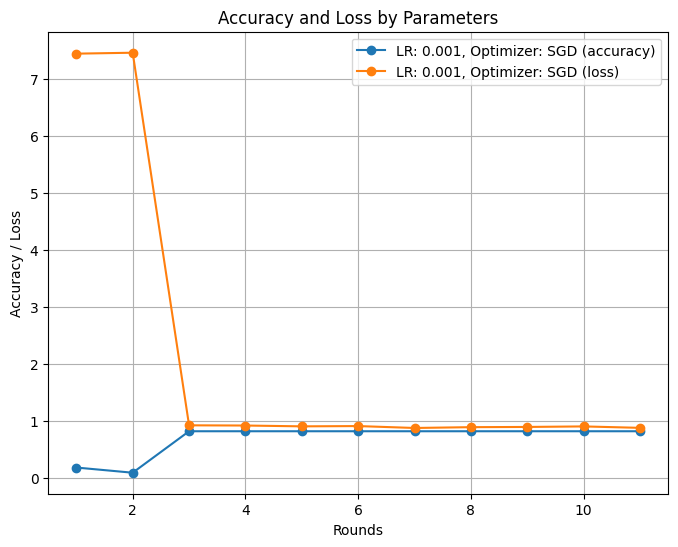

In [44]:
# Make some plots 
global_accuracy,global_loss = ppl_1.server.accuracies,ppl_1.server.losses
results_dict = {
    ('LR: 0.001, Optimizer: SGD', 'accuracy'): global_accuracy,
    ('LR: 0.001, Optimizer: SGD', 'loss'): global_loss
}
plotter = AccuracyLossPlotter(results_dict)

plotter.plot_accuracy_loss()

In [45]:
# Test the Modal on the Test nodes and store the results on the DB
ppl_1.auto_test()

[{'node_name': 'hospital_1',
  'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 5, 'TN': 22}, 'Accuracy': 0.815, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.815, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0}"},
 {'node_name': 'hospital_2',
  'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 2, 'TN': 25}, 'Accuracy': 0.926, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.926, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0}"},
 {'node_name': 'hospital_3',
  'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 2, 'TN': 25}, 'Accuracy': 0.926, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.926, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0}"},
 {'node_name': 'hospital_4',
  'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 4, 'TN': 23}, '

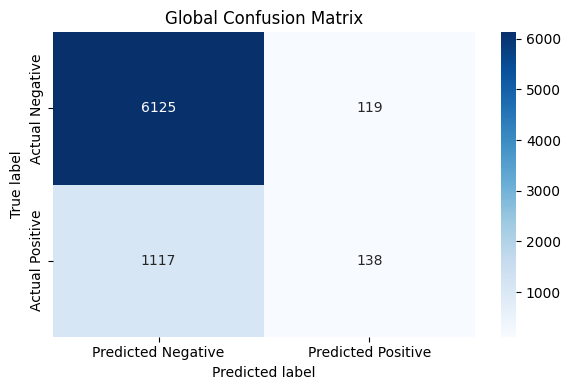

In [46]:
# Plot the Global confusion Matrix of the pipiline "the first fl_pipeline"
AccuracyLossPlotter.plot_global_confusion_matrix(pipeline_name="the first fl_pipeline")

/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/plot.py:226: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


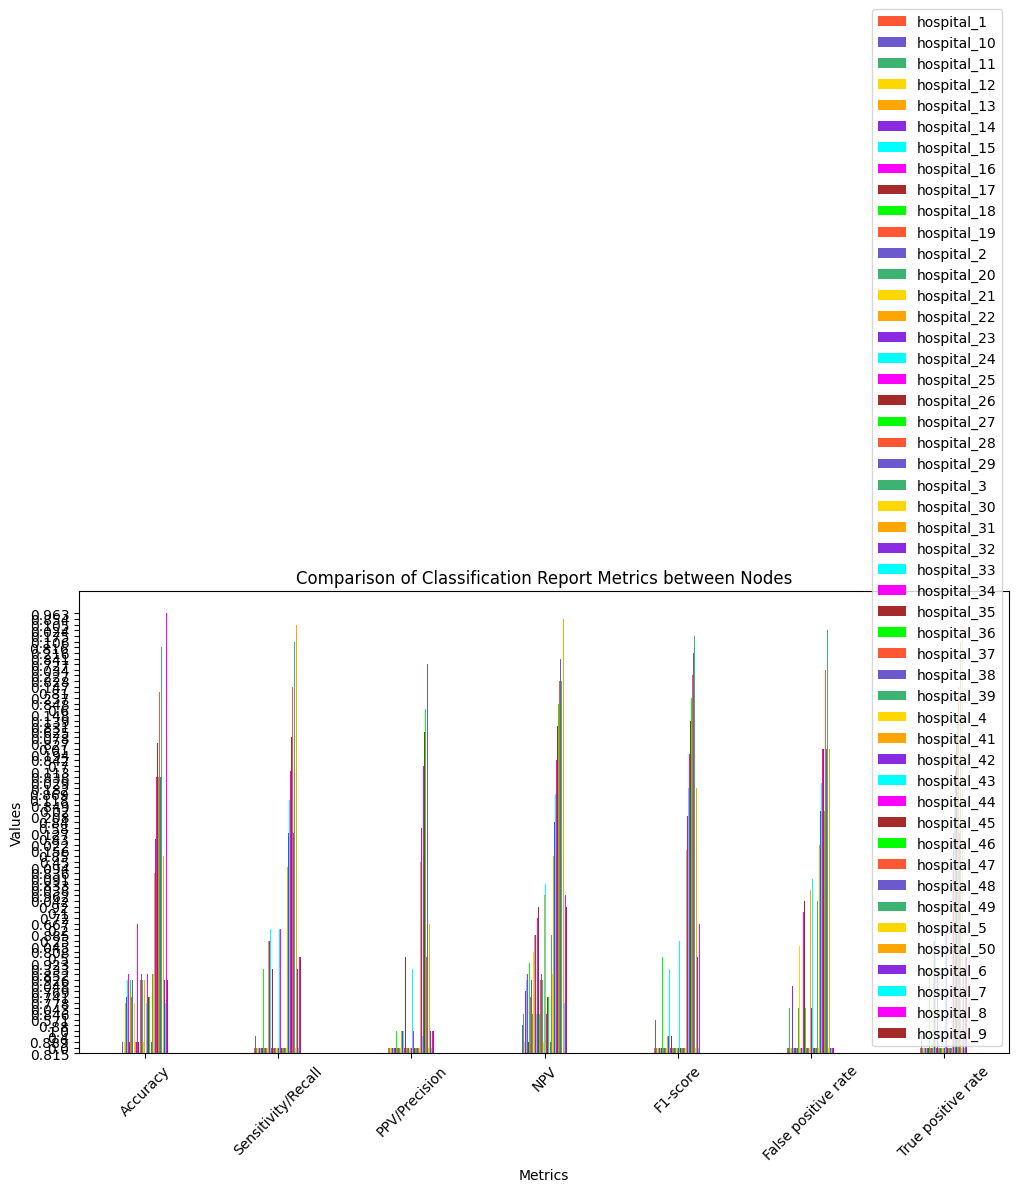

In [47]:
AccuracyLossPlotter.plot_classification_report(pipeline_name="the first fl_pipeline")